# 6.819/6.869 Network Interpretability and Training


In this problem set, we will begin by examining how we can visualize the learned features a pretrained image classifier to better understand how it makes a decision when classifying a particular scene.

Then, you'll train your own simple image classifier and work to improve its performance as much as you can.


# Requirements installation


First, let's install everything needed to run this notebook


In [ ]:
!pip install Pillow==4.1.1
!pip install -U image
!pip install opencv-python
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
!pip install torch
!pip install torchvision

from tqdm import tqdm
from io import BytesIO

import cv2
import numpy as np
import PIL.Image
from IPython.display import Image, clear_output, display

# PyTorch will be out main tool for playing with neural networks
import torch
import torch.hub
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms

# For reproducibility
torch.manual_seed(1234)

# CPU / GPU
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

# Download function for model
import requests
def download(url, fn=None):
    if fn is None:
        fn = url.split('/')[-1]
    r = requests.get(url)
    if r.status_code == 200:
        open(fn, 'wb').write(r.content)
        print("{} downloaded: {:.2f} KB".format(fn, len(r.content) / 1024.0))
    else:
        print("url not found:", url)



  Using cached Pillow-4.1.1-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.0.1
    Uninstalling Pillow-9.0.1:
      Successfully uninstalled Pillow-9.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires pillow!=8.3.0,>=5.3.0, but you have pillow 4.1.1 which is incompatible.
scikit-image 0.18.3 requires pillow!=7.1.0,!=7.1.1,>=4.3.0, but you have pillow 4.1.1 which is incompatible.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 4.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


  Using cached https://github.com/chengs/tqdm/archive/colab.zip
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47880 sha256=51a2ef948662ef0558ca4a87915d2117e2aa5e92b0714c3ad2fea3fbba54447b
  Stored in directory: /tmp/pip-ephem-wheel-cache-ubsse88d/wheels/b5/36/d9/593e7ac06d343d0a32138fa6c402dc3a0bd31442c9fe53f76c
Successfully built tqdm
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 2.2.4 requires tqdm<5.0.0,>=4.38.0, but you have tqdm 4.28.1 which is incompatible.
panel 0.12.1 requires tqdm>=4.48.0, but you have tqdm 4.28.1 which is incompatible.
fbprophet 0.7.1 requires tqdm>=4.36.1, but you have tqdm 4.28.1 which is incompatible.
  Using cached Pillow-9.0.1-cp37-cp37m-manylinux_2_1

We will load PyTorch, our main tool to play with neural networks.


# Loading Images and PyTorch models


Once, we have loaded all the relevant libraries, we will load the model. We will begin with an scene classification model trained on the Places Dataset with a ResNet-50 architecture.

![texto alternativo](https://www.codeproject.com/KB/AI/1248963/resnet.png)


In [ ]:
# Download the pretrained weights
download('http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar')

# Initialize the model
resnet = models.resnet50(num_classes=365)

# Load the model
sd = torch.load('resnet50_places365.pth.tar', map_location=device)['state_dict']

# Don't worry about this -- when you train a model using parallelism, the
# weights begin with model. We have 1 cpu/gpu, so we will fix the name keys
sd = {k.replace('module.', ''): v for k, v in sd.items()}

# Load weights into network
resnet.load_state_dict(sd)

# Important: put network into evaluation mode
# Some networks have layers that do not behave the same during train/eval
# Forgetting this is a very common source of bugs
resnet.eval()

resnet50_places365.pth.tar downloaded: 94990.39 KB


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Problem 1: Visualizing Network Filters


Now, let's write a function to visualize the filters. You have to complete the following code, with one line normalizing the filter values:


torch.Size([64, 3, 7, 7])
Visualizing conv1 filter 0


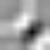

Visualizing conv1 filter 1


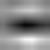

Visualizing conv1 filter 2


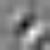

Visualizing conv1 filter 3


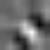

Visualizing conv1 filter 4


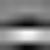

Visualizing conv1 filter 5


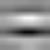

Visualizing conv1 filter 6


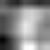

Visualizing conv1 filter 7


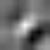

Visualizing conv1 filter 8


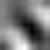

Visualizing conv1 filter 9


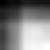

Visualizing conv1 filter 10


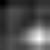

Visualizing conv1 filter 11


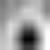

Visualizing conv1 filter 12


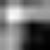

Visualizing conv1 filter 13


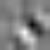

Visualizing conv1 filter 14


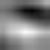

Visualizing conv1 filter 15


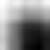

Visualizing conv1 filter 16


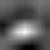

Visualizing conv1 filter 17


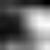

Visualizing conv1 filter 18


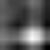

Visualizing conv1 filter 19


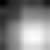

Visualizing conv1 filter 20


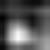

Visualizing conv1 filter 21


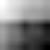

Visualizing conv1 filter 22


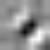

Visualizing conv1 filter 23


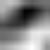

Visualizing conv1 filter 24


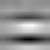

Visualizing conv1 filter 25


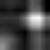

Visualizing conv1 filter 26


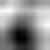

Visualizing conv1 filter 27


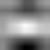

Visualizing conv1 filter 28


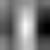

Visualizing conv1 filter 29


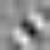

In [ ]:
def showarray(a, fmt='jpeg'):
    ''' Helper function. Use this to show your filters
    
    Converting to standard image format is a common task that produces garbage
    images when not done correctly. We've provided the correct conversions'''
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def normalize_tensor(tensor):
    # TODO (1a): Normalize between 0 and 255, format as np.uint8
    return tensor

print(resnet.conv1.weight.data.size())  # Print the size of conv1 weights

# Display the filters of the initial convolutional layer:
for i in range(30):
    print('Visualizing conv1 filter', i)
    weight = resnet.conv1.weight.data[i, 0, :, :]
    normed = normalize_tensor(weight)

    # Resize
    normed = cv2.resize(normed, (50, 50))
    showarray(normed)


## 1b) Exercise: Visualize filters for another convolutional layer in ResNet


In [ ]:
# TODO (1b): pick a different layer to analyze


# Predicting classes with a pre-trained model


To make the process easier to read, we will load the label <--> index assignment for the Places dataset and one image to use throughout the pset


rio.jpg downloaded: 178.28 KB


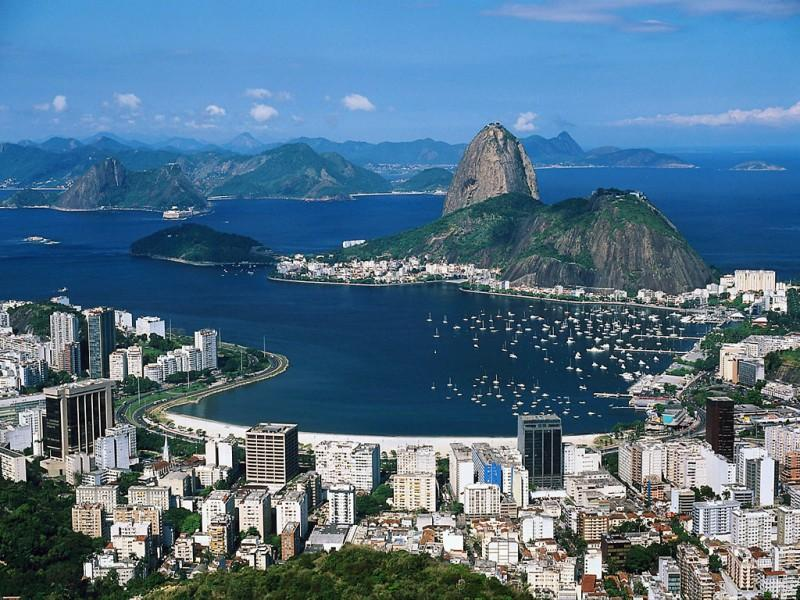

In [ ]:
from urllib.request import urlopen

synset_url = 'http://gandissect.csail.mit.edu/models/categories_places365.txt'
classlabels = [
    r.split(' ')[0][3:] for r in urlopen(synset_url).read().decode('utf-8').split('\n')
]


from torchvision import transforms

download('http://6.869.csail.mit.edu/fa19/miniplaces_part1/rio.jpg')
img_pil = PIL.Image.open('rio.jpg').convert('RGB')
img_numpy = np.array(img_pil)
showarray(img_numpy)

First, let's take a look at the raw prediction of the model.


In [ ]:
# data preprocessing: resize an image, change it from a PIL image to a pytorch tensor, normalize it according to dataset statistics
center_crop = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# our model can only take input that is preprocessed, so preprocess our loaded image
img_tensor = center_crop(img_pil)
logits = resnet(img_tensor.unsqueeze(0)).squeeze()
# get the indices associated with the topk logits
categories = logits.topk(5)[1]

# print the labels corresponding to the topk indices
print(categories)
print(', '.join([classlabels[cat] for cat in categories]))


tensor([194, 348, 171,  49,  97])
islet, village, harbor, beach_house, coast


# Problem 2: Visualizing Internal Activations of the Network

Let's look at what parts of the image cause different units to activate (send some positive signal). All of these activations combine to inform the final inference.

The convolutional layers of ResNet essentially make a semantic representation of what is contained in the image. This is followed by two fully connected layers, which use the information from that representation to categorize the image.

So, let's remove the last few layers (which do classification) to get the underlying representation, and we'll visualize the activations that went into that representation from different units


In [ ]:
def generate_featuremap_unit(model_cut, unit_id, im_input):
    # Extract activation from model
    # Mark the model as being used for inference
    model_cut.eval()
    # Crop the image
    im = center_crop(im_input)
    # Place the image into a batch of size 1, and use the model to get an intermediate representation
    activations = model_cut(im.unsqueeze(0))
    # Print the shape of our representation
    print(activations.size())
    # Extract the only result from this batch, and take just the `unit_id`th channel
    # Return this channel
    return activations.squeeze()[unit_id]

def visualize_featuremap(im_input, feature_map, alpha=0.3):
    # Normalize to [0..1], with a little leeway (0.9999) in case feature_map has 0 range
    feature_map = feature_map / (feature_map.max() + 1e-10)
    # Convert to numpy (detach() just seperates a tensor from the gradient)
    feat_numpy = feature_map.detach().numpy()
    # Resize the feature map to our original image size (our strided conv layers reduce the size of the image)
    feat_numpy = cv2.resize(feat_numpy, (im_input.shape[1], im_input.shape[0]))
    # Invert to make the heatmap look more natural
    map_t = 1 - feat_numpy
    # Add an extra dimension to make this a [H,W,C=1] image
    feat_numpy = np.expand_dims(feat_numpy, axis=2)

    # Convert to image (UINT8 from 0-255)
    map_t = 255 * map_t
    map_t = map_t.astype(np.uint8)
    # Use a color map to change this from BW to a nice color
    map_t = cv2.applyColorMap(map_t, cv2.COLORMAP_JET)
    # Combine the heatmap with the original image so you can see which section of the image is activated
    im_final = np.multiply((alpha * im_input + (1 - alpha) * map_t), feat_numpy) + np.multiply(
        im_input, 1 - feat_numpy
    )
    # Return final visualization
    return im_final


def remove_last_layers(model, num_layers=2):
    # TODO (2a): remove the last 2 layers of resne
    return model


# Note: the .children() function of nn.Module (which resnet50 inherits from) and nn.Sequential() will be useful
model_cut = remove_last_layers(resnet, num_layers=2)

In [ ]:
# TODO (2b): search for mountain, sky, and building units by trying out different values of unit_id
# Fill in these variables with ints
unit_mountain = _
unit_sky      = _
unit_building = _

# Use this to test
feat = generate_featuremap_unit(model_cut, YOUR_UNIT_ID_HERE, img_pil)
im_final = visualize_featuremap(img_numpy, feat)
showarray(im_final)


NameError: ignored

Original top 5 class names  ['islet', 'village', 'harbor', 'beach_house', 'coast']
Original top 5 class values  [10.632541   9.876154   8.220192   7.9328995  7.8490853]
Modified top 5 class names  ['village', 'islet', 'harbor', 'beach_house', 'coast']
Modified top 5 class values  [9.218611  8.29162   7.568083  7.2433043 6.9303694]


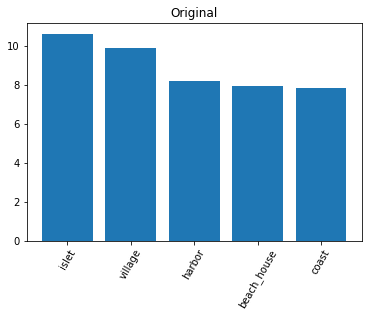

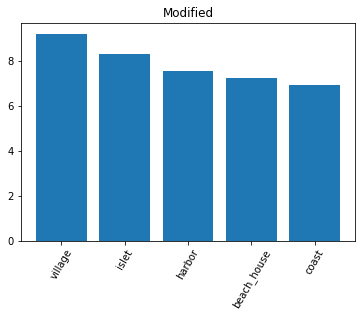

In [ ]:
# TODO (2c -- 6.869 required) Find the unit index that has the maximum weights
# in the fully connected layer and deactivate that unit.
# Compare the orginal prediction and the new prediction
import matplotlib.pyplot as plt

out_original = resnet(img_tensor.unsqueeze(0)).squeeze() # original prediction
class_ids = np.argsort(-out_original.data.cpu().numpy())[0]
index = torch.topk(resnet.fc.weight[class_ids, :], k=5)[1]


def deactivate_unit_activations(model_cut, image, unit_id):
    # TODO: Get the output features for this model. Feature shape should be (1, # units, H, W)

    # TODO: deactivate the unit index that has the maximum weights (Set all values for that unit to 0)

    # TODO: run the modified features through the last two layers of the original network

    return out_modified


def plot_top_classes(values, top_k=5, title=None):
    sorted_classes = np.argsort(-values)
    class_ids = sorted_classes[:top_k]
    class_names = [classlabels[it] for it in list(class_ids)]
    class_values = values[class_ids]
    print(title + " top 5 class names ", class_names)
    print(title + " top 5 class values ", class_values)
    plt.bar(class_names, class_values)
    plt.xticks(rotation=60)
    plt.title(title)
    
# TODO (2d): Report the lowest number of dropped units that change the top class
lowest_dropped_units = _ 

out_modified = deactivate_unit_activations(model_cut, img_tensor, index)

plt.figure(0)
plot_top_classes(out_original.data.cpu().numpy(), title='Original')
plt.figure(1)
plot_top_classes(out_modified.data.cpu().numpy(), title='Modified')


# Problem 3: Visualizing model activations with Class Activation Maps (CAMs)


Once we have load the image and the model, now we will explore how to visualize the internal activations of the model. We will start by visualizing which parts of the image are responsibe for the final decision.

![texto alternativo](https://camo.githubusercontent.com/fb9a2d0813e5d530f49fa074c378cf83959346f7/687474703a2f2f636e6e6c6f63616c697a6174696f6e2e637361696c2e6d69742e6564752f6672616d65776f726b2e6a7067)


We create a version of the model without the last two layers, so that we can access the last convolutional layer.


We compute the activations using the Class Activation Mapping for a given output label.


Visualizing category islet
torch.Size([49, 2048])
torch.Size([49, 365])


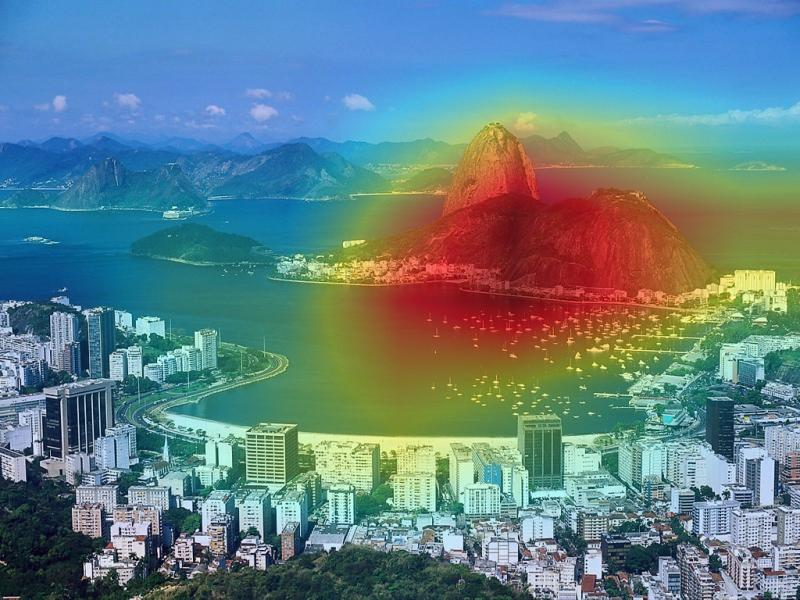

Visualizing category village
torch.Size([49, 2048])
torch.Size([49, 365])


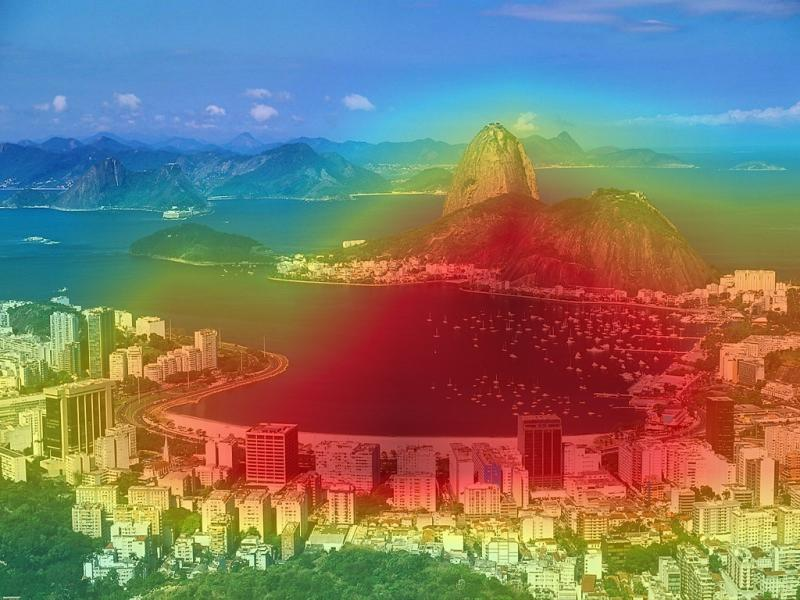

Visualizing category harbor
torch.Size([49, 2048])
torch.Size([49, 365])


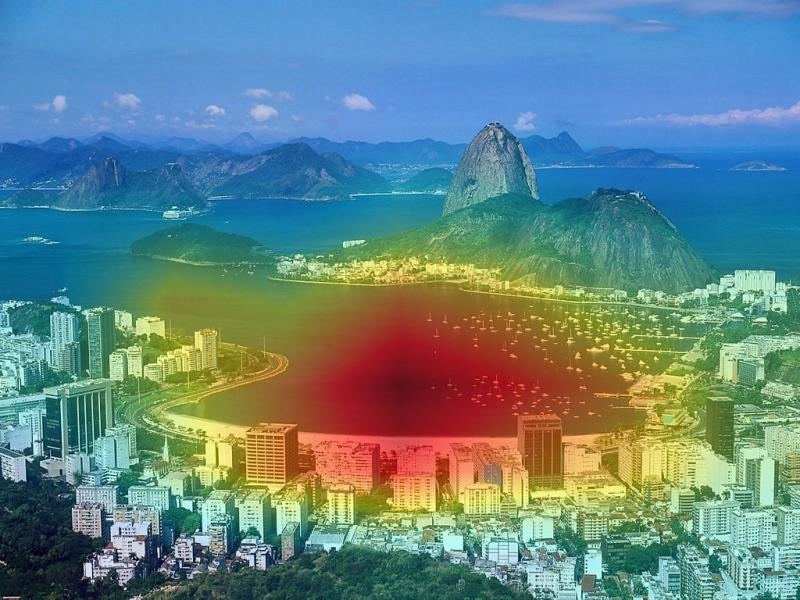

Visualizing category beach_house
torch.Size([49, 2048])
torch.Size([49, 365])


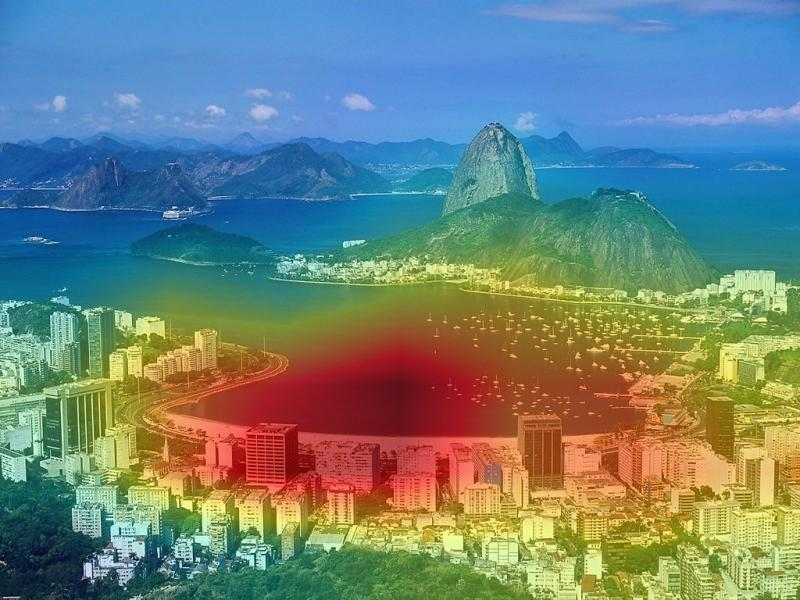

Visualizing category coast
torch.Size([49, 2048])
torch.Size([49, 365])


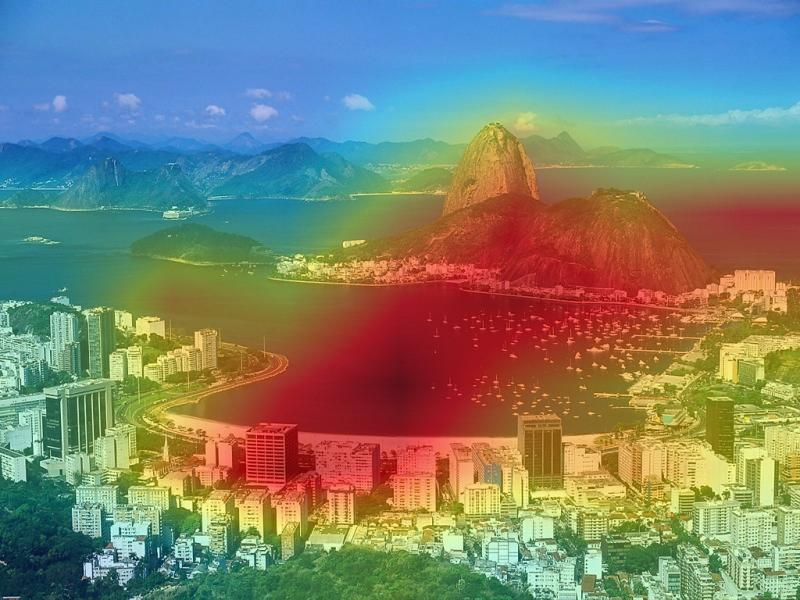

In [ ]:
def generate_featuremap_CAM(model, unit_id, im_input):
    # Extract activation from model
    model.eval()
    im = center_crop(im_input)
    activations = model(im.unsqueeze(0)).squeeze()  # 2048 x h x w
    num_channels, height, width = activations.shape

    # TODO (3a): convert the shape of the output (out variable) to (h*w) x c
    # Purpose of this question: reshaping (.view) tensors can be tricky. The default
    # ordering of dimensions is usually channel first. You may need to .transpose()
    # to correct for this. This is one of the most common sources of bugs in
    # deep NN implementations
    print(activations.shape)

    # TODO (3b): Run the fully connected layer from resnet to compute the weighted average with activations as the input variable
    # out_final should be a h x w x 365 tensor.
    print(out_final.shape)

    # TODO (3c): obtain the class activation map for the corresponding unit_id
    # class_activation_maps should be a 365 x height x width tensor.
    class_activation_maps = None
    return class_activation_maps[unit_id]

# Visualize the most activated region in the image for the 5 top classes
for i in range(categories.shape[0]):
    print('Visualizing category', classlabels[categories[i]])
    feat = generate_featuremap_CAM(model_cut, categories[i].item(), img_pil)
    im_result = visualize_featuremap(img_numpy, feat)
    showarray(im_result)

# Problem 4: Training your own classifier

The goal of this problem is to train a small convolutional neural network to classify images of clothing items from the FashionMNIST dataset. You'll first fill in critical components of a simple PyTorch training pipeline, evaluate the model on the test set, and explore the impact of specific design choices and hyperparameters on the model's performance.

## Building an FashionMNIST Classifier

Using what we have learned, let's build a simple FasionMNIST classifier. Each element of the dataset is a 2-tuple: the 28x28 image and its label.


The [`torchvision`](https://pytorch.org/docs/stable/torchvision/index.html) library provides a wide range of standard vision datasets and networks with pretrained weights. We will use [the `torchvision.datasets.FashionMNIST` class](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST) to easily access the FasionMNIST dataset.

In deep learning, it is often a good idea to normalize network inputs to be centered around zero. We use the [`torchvision.transforms.Normalize`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize) tranform to achieve this. We compose the transforms together using the [`torchvision.transforms.Compose`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose) transform, which allows us to apply multiple transforms sequentially. We provide the following functions to help create the FashionMNIST dataset with these transforms:

In [ ]:
def get_transform(split='train'):
    return transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    )

def get_dataset(split='train', transform=None):
    return datasets.FashionMNIST(
        'data',
        train=split == 'train',
        download=True,
        transform=transform if transform is not None else transforms.ToTensor(),
    )

def get_dataloaders(batch_size=64, num_workers=2):
    '''Use Pytorch torch.utils.data.DataLoader to load batched data'''
    train_dataset = get_dataset('train', get_transform())
    val_dataset = get_dataset('val', get_transform())
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,  # shuffle training set
        num_workers=num_workers,  # turns on multi-processing loading so training is not blocked by data loading
        pin_memory=True,  # pin_memory allows faster transfer from CPU to GPU
    )
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    return train_dataloader, val_dataloader

print('training set size:\t{}'.format(len(get_dataset('train'))))
print('validation set size:\t{}'.format(len(get_dataset('val'))))

# Each element yielded by `train_loader` (a Python iterable) is still a 2-tuple,
# but now consisting of a batched image tensor, and a batched label tensor.
train_loader, _ = get_dataloaders()
images, labels = next(iter(train_loader))

print('batched image tensor shape: {}'.format(images.shape))
print('batched label tensor shape: {}'.format(labels.shape))


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

training set size:	60000
validation set size:	10000
batched image tensor shape: torch.Size([64, 1, 28, 28])
batched label tensor shape: torch.Size([64])


### Building the Network

We will use a convolutional network for classification. The following architecture is adapted from the famous [LeNet-5](https://ieeexplore.ieee.org/document/726791) [1].

[1] LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.


In [ ]:
class MyNet(nn.Module):
    def __init__(
        self,
        num_classes=10,
        kernel_size=5,
        filter1_size=5,
        filter2_size=16,
        fc1_size=120,
        fc2_size=84,
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=filter1_size,
            kernel_size=kernel_size,
            padding=2,
        )
        self.conv2 = nn.Conv2d(
            in_channels=filter1_size,
            out_channels=filter2_size,
            kernel_size=kernel_size,
        )
        self.fc1 = nn.Linear(in_features=filter2_size * kernel_size ** 2, out_features=fc1_size)
        self.fc2 = nn.Linear(in_features=fc1_size, out_features=fc2_size)
        self.fc3 = nn.Linear(in_features=fc2_size, out_features=num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

net = MyNet().to(device)
  
# This network output a size 10 vector for each input image, as verified below
# using a random input tensor.
net(torch.randn(32, 1, 28, 28, device=device)).shape


torch.Size([32, 10])

### **Problem 4(a): Training Loop**

For classification, we will use the cross-entropy loss [`F.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) to train this network.

We write a function that accepts a PyTorch dataloader, model and optimizer (as well as a device and current epoch), and trains the net for 1 epoch (one full pass through the training set).

The next exercise is to fill in the code below. You can use the following pytorch functions:

-   put data on GPU: [to](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html?highlight=#torch.to)
-   clear gradient: [zero_grad](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html?highlight=zero_grad)
-   backward pass: [backward](https://pytorch.org/docs/stable/generated/torch.autograd.backward.html?highlight=backward#torch.autograd.backward)
-   update parameters with a gradient step: [step](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html?highlight=step#torch.optim.Optimizer.step)


In [ ]:
########################
#                      #
#       Exercise       #
#                      #
########################

# Fix the places with a `TODO`

def accuracy(output, target):
    """Computes the accuracy of the model on the test set.

    Args:
        output: the output of the model
        target: the ground truth labels
    Returns:
        the accuracy of the model on the test set
    """
    with torch.no_grad():
        _, predicted = torch.max(output, 1)
        correct = (predicted == target).sum().item()
    return correct / len(target)


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train(dataloader, model, optimizer, epoch):
    model.train()

    train_loss = []
    acc_meter = AverageMeter()
    batches = tqdm(enumerate(dataloader), total=len(dataloader))
    batches.set_description("Epoch NA: Loss (NA) Accuracy (NA %)")
    for batch_idx, (data, target) in batches:

        # TODO: Move data to appropriate device

        # TODO: Zero out gradients

        # TODO: Compute forward pass, loss, and gradients

        # TODO: Update parameters

        # TODO: Compute and record accuracy
        acc = None
        acc_meter.update(acc)

        batches.set_description(
            "Epoch {:d}: Loss ({:.2e}), Train Accuracy ({:02.0f}%)".format(
                epoch, loss.item(), 100.0 * acc_meter.avg
            )
        )

    return train_loss, acc_meter.avg


## Problem 4(b): Evaluating the Model

Let's also write a function that evaluates our network on the validation set.


In [ ]:
########################
#                      #
#       Exercise       #
#                      #
########################

# Fix the places with a TODO


def get_prediction(image, net):
    # TODO!!!  (HINT: use .argmax(dim=-1))
    #   `prediction` should be an integer vector of size equal to the batch size.
    #   Remember that the network outputs logits of the prediction probabilities,
    #   and that the higher the logits, the higher the probability.
    return 

def evaluate(dataloader, net):
    total = 0
    correct = 0

    net.eval()  # puts the network in eval mode. this is important when the
    # network has layers that behaves differently in training and
    # evaluation time, e.g., dropout and batch norm.
    for image, label in dataloader:
        image, label = image.to(device), label.to(device)

        with torch.no_grad():  # gradients are not tracked in this context manager
            # since we are evaluating, gradients are not needed
            # and we can save some time and GPU memory.

            # TODO: Get predictions using function from above

            # TODO: Update total and correct

    return correct / total


In [ ]:
# Without any training, the network accuracy matches that of random guessing: ~10%.
_, val_loader = get_dataloaders(batch_size=32, num_workers=0)
print('At initialization, the network has accuracy {:.4f}%'.format(evaluate(val_loader, net) * 100))


At initialization, the network has accuracy 9.7200%


## **Problem 4(c)** Putting Everything Together


In [ ]:
########################
#                      #
#       Exercise       #
#                      #
########################


# Fix the places with a TODO
num_epochs = 10
lr = 0.01

def create_optimizer(net, lr):
    # TODO: Create optimizer
    return 

optim = create_optimizer(net, lr)
train_loader, val_loader = get_dataloaders(batch_size=128)

for epoch in range(num_epochs):
    print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net) * 100))
    train(train_loader, net, optim, epoch)

valid_accuracy = evaluate(val_loader, net) * 100)
print('Done! \tValidation Accuracy: {:.4f}%'.format(valid_accuracy))


Epoch: 0	Validation Accuracy: 9.7200%


Epoch 0: Loss (4.89e-01), Train Accuracy (81%): 100%|██████████| 469/469 [00:17<00:00, 27.32it/s]


Epoch: 1	Validation Accuracy: 85.4900%


Epoch 1: Loss (3.68e-01), Train Accuracy (87%): 100%|██████████| 469/469 [00:16<00:00, 27.98it/s]


Epoch: 2	Validation Accuracy: 86.5600%


Epoch 2: Loss (2.88e-01), Train Accuracy (88%): 100%|██████████| 469/469 [00:16<00:00, 27.70it/s]


Epoch: 3	Validation Accuracy: 87.4800%


Epoch 3: Loss (3.61e-01), Train Accuracy (89%): 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]


Epoch: 4	Validation Accuracy: 88.0000%


Epoch 4: Loss (3.77e-01), Train Accuracy (89%): 100%|██████████| 469/469 [00:18<00:00, 25.41it/s]


Epoch: 5	Validation Accuracy: 87.6300%


Epoch 5: Loss (3.83e-01), Train Accuracy (89%): 100%|██████████| 469/469 [00:17<00:00, 27.44it/s]


Epoch: 6	Validation Accuracy: 87.9000%


Epoch 6: Loss (3.17e-01), Train Accuracy (90%): 100%|██████████| 469/469 [00:17<00:00, 27.51it/s]


Epoch: 7	Validation Accuracy: 88.3200%


Epoch 7: Loss (2.37e-01), Train Accuracy (90%): 100%|██████████| 469/469 [00:16<00:00, 27.67it/s]


Epoch: 8	Validation Accuracy: 87.9000%


Epoch 8: Loss (2.64e-01), Train Accuracy (90%): 100%|██████████| 469/469 [00:16<00:00, 27.67it/s]


Epoch: 9	Validation Accuracy: 88.3800%


Epoch 9: Loss (2.30e-01), Train Accuracy (90%): 100%|██████████| 469/469 [00:17<00:00, 27.56it/s]


Done! 	Validation Accuracy: 88.4000%


## **Problem 4(d)**

We want you to get a feel for the impact of specific design choices on the performance of the network. Experiment with one of the following hyperparameters / techniques:

-   Data augmentation
-   Weight initialization
-   Number of layers, or number of layer features
-   Type of optimizer
-   Learning rate and/or schedule

**6.869**: Choose at least 2 techniques

For technique(s) you choose, plot the top-1 accuracy of your modified network against the top-1 accuracy of the original network for both the training and validation sets. Try with several different
hyperparameter values! For example, if you choose to modify the learning rate, plot a chart of learning rate vs. top-1 accuracy. **Briefly describe the techniques you tried, and suggest a brief explanation for your results.**

**Save your model as below and include it in your submission. We will not try to find your model if it is not at the root of your zip named "model.pth"**

In [ ]:
torch.save(YOUR_MODEL, 'model.pth')

# We will evaluate your model like this from the root of your zip
# It is your job to make sure this runs
evaluate(val_loader, torch.load('model.pth'))